In [1]:
import numpy as np

def simulate_vasicek_euler(r0, kappa, theta, sigma, T, dt, seed=None):
    np.random.seed(seed)
    N = int(T / dt)
    rates = np.zeros(N)
    rates[0] = r0
    
    for t in range(1, N):
        dr = kappa * (theta - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates[t] = rates[t-1] + dr
        
    return rates


In [2]:
def simulate_vasicek_exact(r0, kappa, theta, sigma, T, dt, seed=None):
    np.random.seed(seed)
    N = int(T / dt)
    rates = np.zeros(N)
    rates[0] = r0
    exp_kappa_dt = np.exp(-kappa * dt)
    
    for t in range(1, N):
        mean = theta + (rates[t-1] - theta) * np.exp(-kappa * dt)
        variance = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * dt))**2
        rates[t] = np.random.normal(mean, np.sqrt(variance))
        
    return rates


In [78]:
from scipy.optimize import minimize

def vasicek_log_likelihood(params, r):
    kappa, theta, sigma = params
    r0 = r[0]
    dt = 1 / 252
    N = len(r)
    
    mean = r[:-1] * np.exp(-kappa * dt) + (theta * (1 - np.exp(-kappa * dt))) / kappa
    variance = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * dt))
    logL = np.sum(
        -0.5 * (np.log(2 * np.pi * variance)) - 
        (r[1:] - mean)**2 / (2 * variance)
    )
    
    return -logL

def calibrate_vasicek_mle(r):
    initial_params = [0.15, np.mean(r), np.std(np.diff(r)) * np.sqrt(252)]
    print(initial_params)
    bounds = [(1e-6, 1), (None, None), (1e-6, None)]
    result = minimize(vasicek_log_likelihood, initial_params, args=(r,), bounds=bounds, method='L-BFGS-B')
    kappa, theta, sigma = result.x
    return kappa, theta, sigma


In [79]:
from scipy.optimize import minimize

def vasicek_moments(params, r):
    kappa, theta, sigma = params
    r0 = r[0]
    dt = 1 / 252 # Assuming daily data, dt can be changed accordingly
    N = len(r)
    
    m1 = np.mean(r[1:] - r[:-1]) - kappa * (theta - np.mean(r[:-1])) * dt
    m2 = np.mean((r[1:] - r[:-1])**2) - sigma**2 * dt
    
    return np.array([m1, m2])

def vasicek_gmm_objective(params, r):
    moments = vasicek_moments(params, r)
    return np.sum(moments**2)

def calibrate_vasicek_gmm(r):
    initial_params = [0.15, np.mean(r), 0.15]
    bounds = [(0, None), (None, None), (0, None)]
    result = minimize(vasicek_gmm_objective, initial_params, args=(r,), bounds=bounds)
    kappa, theta, sigma = result.x
    return kappa, theta, sigma


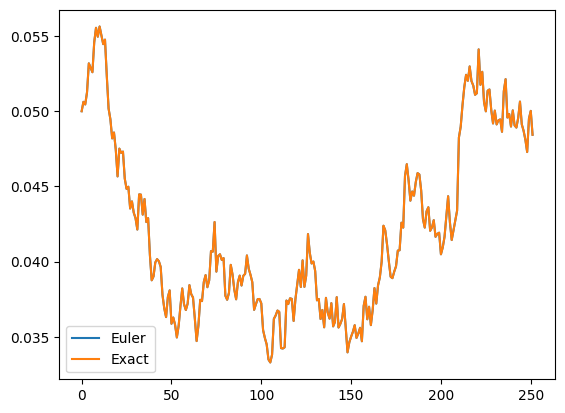

[0.15, 0.04212931365956407, 0.019309342522682422]
MLE calibrated parameters: kappa=1.0, theta=0.04052977097534366, sigma=0.019310503328675954
GMM calibrated parameters: kappa=0.15, theta=0.04212931365956407, sigma=0.15


In [80]:
import matplotlib.pyplot as plt

# Simulation parameters
r0 = 0.05
kappa = 0.1
theta = 0.05
sigma = 0.02
T = 1.0  # Total time in years
dt = 1/252  # Daily time steps
seed = 42

# Simulate using Euler discretization
rates_euler = simulate_vasicek_euler(r0, kappa, theta, sigma, T, dt, seed)
plt.plot(rates_euler, label='Euler')

# Simulate using exact discretization
rates_exact = simulate_vasicek_exact(r0, kappa, theta, sigma, T, dt, seed)
plt.plot(rates_exact, label='Exact')

plt.legend()
plt.show()

# Calibration parameters
market_rates = rates_exact  # Assuming market observed short rates are the simulated exact rates

# MLE Calibration
kappa_mle, theta_mle, sigma_mle = calibrate_vasicek_mle(market_rates)
print(f'MLE calibrated parameters: kappa={kappa_mle}, theta={theta_mle}, sigma={sigma_mle}')

# GMM Calibration
kappa_gmm, theta_gmm, sigma_gmm = calibrate_vasicek_gmm(market_rates)
print(f'GMM calibrated parameters: kappa={kappa_gmm}, theta={theta_gmm}, sigma={sigma_gmm}')


In [71]:
import numpy as np

def zero_coupon_bond_price(r_t, kappa, theta, sigma, T, t=0):
    """
    Computes the price of a zero-coupon bond in the Vasicek model.

    Parameters:
    r_t (float): Current short rate.
    kappa (float): Speed of mean reversion.
    theta (float): Long-term mean level of the short rate.
    sigma (float): Volatility of the short rate.
    T (float): Maturity time of the bond.
    t (float): Current time. Default is 0 (i.e., pricing at time t=0).

    Returns:
    float: Price of the zero-coupon bond.
    """
    tau = T - t
    
    B = (1 - np.exp(-kappa * tau)) / kappa
    A = np.exp((theta - (sigma**2) / (2 * kappa**2)) * (B - tau) - (sigma**2) * (B**2) / (4 * kappa))
    
    P = A * np.exp(-B * r_t)
    return P

# Example usage
r_t = 0.05  # Current short rate
kappa = 0.1
theta = 0.05
sigma = 0.02
T = 1.0  # Maturity time in years

# Compute the zero-coupon bond price
price = zero_coupon_bond_price(r_t, kappa, theta, sigma, T)
print(f"Zero-coupon bond price: {price}")


Zero-coupon bond price: 0.9512882997253278
